# ARPA Lombardia Ground Sensors- Air quality and meteorological preprocessing

- Ground sensor's type and position is retrived by the ARPA API: [Air quality stations](https://www.dati.lombardia.it/Ambiente/Stazioni-qualit-dell-aria/ib47-atvt) and [Meteorological stations](https://www.dati.lombardia.it/Ambiente/Stazioni-Meteorologiche/nf78-nj6b)
- ARPA API provides data for the current year only (from Jenuary 2022): [API Air quality data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria/nicp-bhqi) and  [API Meteorological data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo/647i-nhxk)
- To use data from previous years it's required to use the dataset in .csv format, such as [Air quality data for 2020]( https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria-2020/88sp-5tmj) or [Meteorological data for 2020](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo-2020/erjn-istm). The ARPA_URL_by_year function contains the links for downloading the data for the year chosen.

In this notebook sensors position and type are retrieved from the API only, while time series are retreived by .csv or API depending on the year (if before 2022 is only possible to use the .csv file, while for 2022 data from API are available)

Notes:<br>
**Air quality .csv data are still not available for 2021.** <br>
**Meteorological data of Jenuary 2022 are retreivable from API, but the .csv for 2021 is not available.**


The "app_token" is required to access the data. <br>
Example video tutorial: https://www.youtube.com/watch?v=3p4gncGaSeg&t=899s&ab_channel=CharmingData <br>
Register on "Open Data Lombardia" to get tokens: https://www.dati.lombardia.it/login

**Data Interpolation:** at the end of the notebook is possible to intepolate sensor data using Ordinary Kriging Method (using [pykrige](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/) library) over the region.

## Import libraries

In [ ]:
# !pip install sodapy

In [2]:
from sodapy import Socrata
import pandas as pd
import geopandas as gpd
import os
import zipfile
import requests
import json
from scipy import stats
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets

In [3]:
cwd = os.getcwd()

In [4]:
from functions import my_methods  #function where each year is associated to the resource link (for downloading the .csv file)

Modify **date.json** file to change the date:

In [5]:
d = open('date.json')
date = json.load(d)
year = date['year']
mais_week = date['mais_week']
rice_week = date['rice_week']
cereal_week = date['cereal_week']

In [6]:
calendar = my_methods.manuring_periods(year, mais_week, rice_week, cereal_week)
print(calendar)

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: ['2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01'], 10: [], 11: [], 12: [], 13: ['2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29'], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: ['2020-08-24', '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29', '2020-08-30'], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [], 53: []}


In [7]:
# With this widget is possible to select from the dropdown list the required week
select_week = widgets.Dropdown(
    options=['mais_week', 'rice_week', 'cereal_week'],
    description='name:',
    disabled=False)
select_week

Dropdown(description='name:', options=('mais_week', 'rice_week', 'cereal_week'), value='mais_week')

In [8]:
start_date = calendar[date[select_week.value]][0]
end_date = calendar[date[select_week.value]][-1]
start_date

'2020-02-24'

In [9]:
date_object = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
year = str(date_object.year)

In [10]:
#Only for current year data
start_date_api = '"'+start_date+'"'
end_date_api = '"'+end_date+'"'

In [11]:
year

'2020'

In [12]:
f = open('keys.json')
keys = json.load(f)

Z-Score threshold:

In [13]:
threshold = 3

---

# Import stations and sensor type from ARPA API

Import sensors description and position from the API.

In [14]:
arpa_domain = "www.dati.lombardia.it"
st_descr = "ib47-atvt"

In [15]:
client = Socrata(arpa_domain, app_token = keys['arpa_token'])  #insert your arpa_token

In [16]:
results = client.get_all(st_descr)

In [17]:
air_st_descr = pd.DataFrame(results)

In [18]:
air_st_descr["idsensore"] = air_st_descr["idsensore"].astype(str).astype(int)

- - - 

<a id='aq_data_api'></a>
# Import air quality data from ARPA API

Skip to [air quality import from .csv](#aq_data_csv) data if required. The API works for current year data only.

In [ ]:
arpa_domain = "www.dati.lombardia.it"
dati = "nicp-bhqi" #change this depending on the dataset (check Open Data Lombardia datasets)

In [ ]:
client = Socrata(arpa_domain, app_token = "riTLzYVRVdDaQtUkxDDaHRgJi")

In [ ]:
date_query = "data > {} and data < {}".format(start_date_api,end_date_api)
date_query

In [ ]:
results = client.get(dati, where=date_query, limit=5000000000)

In [ ]:
aq_data = pd.DataFrame(results)

In [ ]:
aq_data['data'] =  pd.to_datetime(aq_data['data'], format='%Y/%m/%d %H:%M:%S')

In [ ]:
aq_data = aq_data.astype({"idsensore": int,"valore": float})

- - -

<a id='aq_data_csv'></a>
# Import air quality data from .csv

Go back to [air quality import from API](#aq_data_api) data if required. Used to access data from past years (not current one).

Example using air quality data 2020 from ARPA stations: https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria-2020/88sp-5tmj

Download the .csv data for the selected year in a zip folder. Read the .csv file and put it in a dataframe:
- missing 2021 data for now

In [19]:
csv_url = my_methods.AQ_sensor(year)
r = requests.get(csv_url, allow_redirects=True)
DL_zip = open('aq_'+str(year)+'.zip', 'wb').write(r.content)
archive = zipfile.ZipFile('aq_'+str(year)+'.zip', 'r')
data = archive.open(str(year)+'.csv')

In [20]:
aq_data=pd.read_csv(data)
aq_data

,IdSensore,Data,Valore,Stato,idOperatore
0,5652,01/01/2020 00:00:00,-9999.0,NaN,1
1,5710,01/01/2020 00:00:00,-9999.0,NaN,1
2,6411,01/01/2020 00:00:00,1.0,VA,1
3,5504,01/01/2020 00:00:00,125.0,VA,1
4,5507,01/01/2020 00:00:00,63.8,VA,1
...,...,...,...,...,...
2620275,30159,31/12/2020 23:00:00,44.6,VA,1
2620276,30160,31/12/2020 23:00:00,38.9,VA,1
2620277,30162,31/12/2020 23:00:00,75.4,VA,1
2620278,30163,31/12/2020 23:00:00,44.8,VA,1


Rename columns:

In [21]:
aq_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)

Set date format:

In [22]:
aq_data['data'] =  pd.to_datetime(aq_data['data'], format='%d/%m/%Y %H:%M:%S')

In [23]:
aq_data

,idsensore,data,valore,stato,idoperatore
0,5652,2020-01-01 00:00:00,-9999.0,NaN,1
1,5710,2020-01-01 00:00:00,-9999.0,NaN,1
2,6411,2020-01-01 00:00:00,1.0,VA,1
3,5504,2020-01-01 00:00:00,125.0,VA,1
4,5507,2020-01-01 00:00:00,63.8,VA,1
...,...,...,...,...,...
2620275,30159,2020-12-31 23:00:00,44.6,VA,1
2620276,30160,2020-12-31 23:00:00,38.9,VA,1
2620277,30162,2020-12-31 23:00:00,75.4,VA,1
2620278,30163,2020-12-31 23:00:00,44.8,VA,1


Select date range:

In [24]:
mask = (aq_data.data >= start_date) & (aq_data.data <= end_date)
aq_data = aq_data.loc[mask]

- - -

# Air quality data processing

Drop "stato" and "idoperatore" columns and select valid values different from -9999:

In [25]:
aq_data = aq_data.drop(columns=['stato', 'idoperatore'])

In [26]:
aq_data = aq_data[aq_data.valore.astype(float) != -9999]

Z-Test to remove outliers:

In [27]:
aq_data['zscore'] = np.abs(stats.zscore(aq_data['valore'], nan_policy='propagate'))
# print(np.where(aq_data['zscore'] > 3))
aq_data = aq_data[aq_data.zscore < threshold]

This part calculates the mean value for each sensor in the time range provided:

In [28]:
aq_means = aq_data.groupby(['idsensore'],as_index=False).mean()

Join sensors description and information with the mean value:

In [29]:
aq_table = pd.merge(aq_means, air_st_descr, on='idsensore')

Get the unique sensor type names:

In [30]:
air_st_descr.nometiposensore.unique()

array(['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto',
       'Biossido di Zolfo', 'Particelle sospese PM2.5', 'Benzene',
       'Ozono', 'PM10 (SM2005)', 'Particolato Totale Sospeso',
       'Ammoniaca', 'Nikel', 'Arsenico', 'Cadmio', 'Piombo',
       'Benzo(a)pirene', 'BlackCarbon', 'Monossido di Azoto', 'PM10'],
      dtype=object)

Select sensors adding their names to the list:

In [31]:
sensor_sel = ['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto','Ozono',
       'Biossido di Zolfo', 'Particelle sospese PM2.5','Ammoniaca','PM10 (SM2005)']

In [32]:
aq_table['nometiposensore'].astype(str)
aq_table = aq_table[aq_table['nometiposensore'].isin(sensor_sel)]

Save sensors separately and create a .gpkg file for each one:

In [33]:
# nox = aq_table.loc[aq_table['nometiposensore'] == 'Ossidi di Azoto']
pm25 = aq_table.loc[aq_table['nometiposensore'] == 'Particelle sospese PM2.5']
co = aq_table.loc[aq_table['nometiposensore'] == 'Monossido di Carbonio']
no2 = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Azoto']
so2 = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Zolfo']
nh3 = aq_table.loc[aq_table['nometiposensore'] == 'Ammoniaca']
nox = aq_table.loc[aq_table['nometiposensore'] == 'Ossidi di Azoto']
pm10 = aq_table.loc[aq_table['nometiposensore'] == 'PM10 (SM2005)']
ozono = aq_table.loc[aq_table['nometiposensore'] == 'Ozono']

In [34]:
pm25_gdf = gpd.GeoDataFrame(pm25, geometry=gpd.points_from_xy(pm25.lng, pm25.lat))
pm25_gdf = pm25_gdf.set_crs('epsg:4326')

In [35]:
co_gdf = gpd.GeoDataFrame(co, geometry=gpd.points_from_xy(co.lng, co.lat))
co_gdf = co_gdf.set_crs('epsg:4326', inplace=True)

In [36]:
no2_gdf = gpd.GeoDataFrame(no2, geometry=gpd.points_from_xy(no2.lng, no2.lat))
no2_gdf = no2_gdf.set_crs('epsg:4326')

In [37]:
so2_gdf = gpd.GeoDataFrame(so2, geometry=gpd.points_from_xy(so2.lng, so2.lat))
so2_gdf = so2_gdf.set_crs('epsg:4326')

In [38]:
nh3_gdf = gpd.GeoDataFrame(nh3, geometry=gpd.points_from_xy(nh3.lng, nh3.lat))
nh3_gdf = nh3_gdf.set_crs('epsg:4326')

In [39]:
nox_gdf = gpd.GeoDataFrame(nox, geometry=gpd.points_from_xy(nox.lng, nox.lat))
nox_gdf = nox_gdf.set_crs('epsg:4326')

In [40]:
pm10_gdf = gpd.GeoDataFrame(pm10, geometry=gpd.points_from_xy(pm10.lng, pm10.lat))
pm10_gdf = pm10_gdf.set_crs('epsg:4326')

In [41]:
ozono_gdf = gpd.GeoDataFrame(ozono, geometry=gpd.points_from_xy(ozono.lng, ozono.lat))
ozono_gdf = ozono_gdf.set_crs('epsg:4326')

Create a **temp** folder:

In [ ]:
pm25_gdf.to_file(cwd+"/temp/pm25_st.gpkg", driver="GPKG")
co_gdf.to_file(cwd+"/temp/co_st.gpkg", driver="GPKG")
no2_gdf.to_file(cwd+"/temp/no2_st.gpkg", driver="GPKG")
so2_gdf.to_file(cwd+"/temp/so2_st.gpkg", driver="GPKG")
nh3_gdf.to_file(cwd+"/temp/amm_st.gpkg", driver="GPKG")
nox_gdf.to_file(cwd+"/temp/nox_st.gpkg", driver="GPKG")
pm10_gdf.to_file(cwd+"/temp/pm10_st.gpkg", driver="GPKG")
ozono_gdf.to_file(cwd+"/temp/o3_st.gpkg", driver="GPKG")

- - -

# Import meteorological stations from ARPA API

https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo-2020/erjn-istm

In [110]:
arpa_domain = "www.dati.lombardia.it"
m_st_descr = "nf78-nj6b"

In [111]:
client = Socrata(arpa_domain, app_token = "riTLzYVRVdDaQtUkxDDaHRgJi")

In [112]:
results = client.get_all(m_st_descr)

In [113]:
meteo_st_descr = pd.DataFrame(results)

In [114]:
meteo_st_descr["idsensore"] = meteo_st_descr["idsensore"].astype(str).astype(int)

In [115]:
meteo_st_descr

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,100,Precipitazione,mm,52,Grosio Diga Fusino,1220,SO,2002-01-01T00:00:00.000,N,5131141,595908,10.245970197827939,46.327055775545546,"{'latitude': '46.327055775545546', 'longitude'...",3,3,NaN
1,101,Altezza Neve,cm,52,Grosio Diga Fusino,1220,SO,2001-12-01T00:00:00.000,N,5131141,595908,10.245970197827939,46.327055775545546,"{'latitude': '46.327055775545546', 'longitude'...",3,3,NaN
2,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13T00:00:00.000,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",1,1,NaN
3,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
4,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,99,Temperatura,°C,52,Grosio Diga Fusino,1220,SO,2001-12-01T00:00:00.000,N,5131141,595908,10.245970197827939,46.327055775545546,"{'latitude': '46.327055775545546', 'longitude'...",3,3,NaN
1258,9933,Precipitazione,mm,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN
1259,9935,Radiazione Globale,W/m²,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN
1260,9938,Temperatura,°C,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN


- - -

<a id='meteo_data_api'></a>
# Import meteorological data from API

Skip to [meteorological data import from .csv](#meteo_data_csv) data if required. The API works for current year data only.
- missing jenuary 2022

In [ ]:
arpa_domain = "www.dati.lombardia.it"
dati = "647i-nhxk" #change this depending on the dataset (check Open Data Lombardia datasets)

In [ ]:
client = Socrata(arpa_domain, app_token = keys['arpa_token']) #insert your arpa_token

The date must be changed from the following request:

In [ ]:
date_query = "data > {} and data < {}".format(start_date_api,end_date_api)
date_query

In [ ]:
results = client.get(dati, where=date_query, limit=5000000000)

In [ ]:
meteo_data = pd.DataFrame(results)
meteo_data

In [ ]:
meteo_data['data'] =  pd.to_datetime(meteo_data['data'], format='%Y/%m/%d %H:%M:%S')

In [ ]:
meteo_data = meteo_data.astype({"idsensore": int,"valore": float})

<a id='meteo_data_csv'></a>
# Import climate data from ARPA .csv file

Go back to [meteorological data import from API](#meteo_data_api) data if required. Used to access data from past years (not current one).

Download the .csv data for the selected year in a zip folder. Read the .csv file and put it in a dataframe:

In [116]:
csv_url = my_methods.meteo_sensor(year)
r = requests.get(csv_url, allow_redirects=True)
DL_zip = open('meteo_'+str(year)+'.zip', 'wb').write(r.content)
archive = zipfile.ZipFile('meteo_'+str(year)+'.zip', 'r')
data = archive.open(str(year)+'.csv')

In [117]:
meteo_data = pd.read_csv(data, dtype={"IdSensore": int,"Valore": float, "Stato": str, "idOperatore":str})

Rename columns:

In [118]:
meteo_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
meteo_data

,idsensore,data,valore,stato,idoperatore
0,9,01/01/2020 00:00:00,0.0,VA,4
1,46,01/01/2020 00:00:00,0.0,VA,4
2,115,01/01/2020 00:00:00,2.9,VA,1
3,116,01/01/2020 00:00:00,0.0,VA,4
4,117,01/01/2020 00:00:00,214.0,VA,1
...,...,...,...,...,...
61502700,12713,31/12/2020 23:50:00,2.7,VA,3
61502701,12712,31/12/2020 23:50:00,262.0,VA,3
61502702,11653,31/12/2020 23:50:00,2.0,VA,3
61502703,11839,31/12/2020 23:50:00,12.0,VA,3


Set date format:

In [119]:
meteo_data['data'] =  pd.to_datetime(meteo_data['data'], format='%d/%m/%Y %H:%M:%S')

Filter date range:

In [120]:
mask = (meteo_data.data >= start_date) & (meteo_data.data <= end_date)
meteo_data = meteo_data.loc[mask]

- - -

# Meteorological data processing 

Drop "stato", "idoperatore" columns and select valid data different from -9999:

In [121]:
meteo_data = meteo_data.drop(columns=['stato', 'idoperatore'])

In [122]:
meteo_data = meteo_data[meteo_data.valore.astype(float) != -9999]

In [123]:
meteo_data['zscore'] = np.abs(stats.zscore(meteo_data['valore'], nan_policy='propagate'))
# print(np.where(aq_data['zscore'] > 3))
meteo_data = meteo_data[meteo_data.zscore < threshold]

Calculate mean value for each sensor in the time range:

In [124]:
meteo_means = meteo_data.groupby(['idsensore'],as_index=False).mean()

Join sensors description and information:

In [125]:
meteo_table = pd.merge(meteo_means, meteo_st_descr, on = 'idsensore')

Get sensors unique types:

In [126]:
meteo_st_descr.tipologia.unique()

array(['Precipitazione', 'Altezza Neve', 'Temperatura',
       'Umidità Relativa', 'Radiazione Globale', 'Direzione Vento',
       'Velocità Vento', 'Livello Idrometrico'], dtype=object)

Select sensors adding to the following list:

In [127]:
m_sensor_sel = ['Precipitazione','Temperatura','Umidità Relativa','Direzione Vento','Velocità Vento', 'Radiazione Globale']

In [128]:
meteo_table['tipologia'].astype(str)
meteo_table = meteo_table[meteo_table['tipologia'].isin(m_sensor_sel)]

Save sensors separately and create a .gpkg file for each one:

In [129]:
temp_st = meteo_table.loc[meteo_table['tipologia'] == 'Temperatura']
prec_st = meteo_table.loc[meteo_table['tipologia'] == 'Precipitazione']
air_hum_st = meteo_table.loc[meteo_table['tipologia'] == 'Umidità Relativa']
wind_dir_st = meteo_table.loc[meteo_table['tipologia'] == 'Direzione Vento']
wind_speed_st = meteo_table.loc[meteo_table['tipologia'] == 'Velocità Vento']
rad_glob_st = meteo_table.loc[meteo_table['tipologia'] == 'Radiazione Globale']

In [130]:
temp_gdf = gpd.GeoDataFrame(temp_st, geometry=gpd.points_from_xy(temp_st.lng, temp_st.lat))
temp_gdf = temp_gdf.set_crs('epsg:4326')

In [131]:
prec_gdf = gpd.GeoDataFrame(prec_st, geometry=gpd.points_from_xy(prec_st.lng, prec_st.lat))
prec_gdf = prec_gdf.set_crs('epsg:4326')

In [132]:
air_hum_gdf = gpd.GeoDataFrame(air_hum_st, geometry=gpd.points_from_xy(air_hum_st.lng, air_hum_st.lat))
air_hum_gdf = air_hum_gdf.set_crs('epsg:4326')

In [133]:
wind_dir_gdf = gpd.GeoDataFrame(wind_dir_st, geometry=gpd.points_from_xy(wind_dir_st.lng, wind_dir_st.lat))
wind_dir_gdf = wind_dir_gdf.set_crs('epsg:4326')

In [134]:
wind_speed_gdf = gpd.GeoDataFrame(wind_speed_st, geometry=gpd.points_from_xy(wind_speed_st.lng, wind_speed_st.lat))
wind_speed_gdf = wind_speed_gdf.set_crs('epsg:4326')

In [135]:
rad_glob_gdf = gpd.GeoDataFrame(rad_glob_st, geometry=gpd.points_from_xy(rad_glob_st.lng, rad_glob_st.lat))
rad_glob_gdf = rad_glob_gdf.set_crs('epsg:4326')

In [136]:
temp_gdf.to_file(cwd+"/temp/temp_st.gpkg", driver="GPKG")
prec_gdf.to_file(cwd+"/temp/prec_st.gpkg", driver="GPKG")
air_hum_gdf.to_file(cwd+"/temp/air_hum_st.gpkg", driver="GPKG")
wind_dir_gdf.to_file(cwd+"/temp/wind_dir_st.gpkg", driver="GPKG")
wind_speed_gdf.to_file(cwd+"/temp/wind_speed_st.gpkg", driver="GPKG")
rad_glob_gdf.to_file(cwd+"/temp/rad_glob_st.gpkg", driver="GPKG")

# Sensor interpolation using Ordinary Kriging method

In [42]:
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
import os
from osgeo import gdal
from osgeo import ogr
import rasterio as rio
from rasterio.transform import Affine
from rasterio.crs import CRS
import numpy as np
import matplotlib.pyplot as plt
import math

In [43]:
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [44]:
pm25_gdf = pm25_gdf.to_crs('epsg:32632')
co_gdf = co_gdf.to_crs('epsg:32632')
no2_gdf = no2_gdf.to_crs('epsg:32632')
so2_gdf = so2_gdf.to_crs('epsg:32632')
nh3_gdf = nh3_gdf.to_crs('epsg:32632')
nox_gdf = nox_gdf.to_crs('epsg:32632')
pm10_gdf = pm10_gdf.to_crs('epsg:32632')
ozono_gdf = ozono_gdf.to_crs('epsg:32632')

In [137]:
temp_gdf = temp_gdf.to_crs('epsg:32632')
prec_gdf = prec_gdf.to_crs('epsg:32632')
air_hum_gdf = air_hum_gdf.to_crs('epsg:32632')
wind_dir_gdf = wind_dir_gdf.to_crs('epsg:32632')
wind_speed_gdf = wind_speed_gdf.to_crs('epsg:32632')
rad_glob_gdf = rad_glob_gdf.to_crs('epsg:32632')

In [138]:
bb = gdal.Open(cwd+"/bounding_box/bounding_box_buffer20_raster_32632.tif")
gt = bb.GetGeoTransform()

In [48]:
gt

(437922.9288, 686.8030422330097, 0.0, 5188927.2639, 0.0, -1008.4656673003796)

In [49]:
ulx = gt[0]
uly = gt[3]
resx = gt[1]
resy = gt[5]
xsize = bb.RasterXSize
ysize = bb.RasterYSize
lrx = ulx + xsize * resx
lry = uly + ysize * resy

In [50]:
xsize, ysize

(412, 263)

In [51]:
ulx, uly

(437922.9288, 5188927.2639)

In [52]:
lrx, lry

(720885.7822, 4923700.7934)

In [53]:
rRes = 1000

In [54]:
# For now interpolate all the ARPA/ESA stations. 
# Must implement a check if number of station over the Lombardy region is too low -> don't interpolate

In [55]:
xRange = np.arange(ulx,lrx+rRes,rRes)
yRange = np.arange(lry,uly+rRes,rRes)
gridX,gridY = np.meshgrid(xRange, yRange)

In [139]:
aq_dict = {'pm25_gdf':pm25_gdf, 'co_gdf':co_gdf, 'no2_gdf':no2_gdf, 'so2_gdf':so2_gdf,
           'nh3_gdf':nh3_gdf, 'nox_gdf':nox_gdf, 'pm10_gdf':pm10_gdf, 'o3_gdf':ozono_gdf}

meteo_dict = {'temp_gdf':temp_gdf, 'prec_gdf':prec_gdf, 'air_hum_gdf':air_hum_gdf, 'wind_dir_gdf':wind_dir_gdf,
           'wind_speed_gdf':wind_speed_gdf, 'rad_glob_gdf':rad_glob_gdf}

pm25_gdf


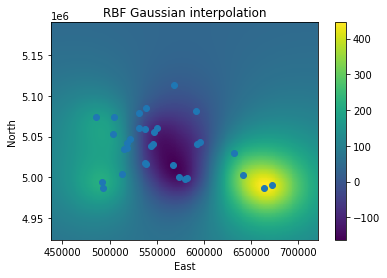

co_gdf


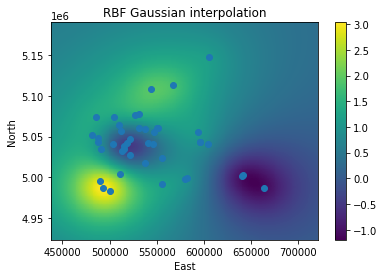

no2_gdf


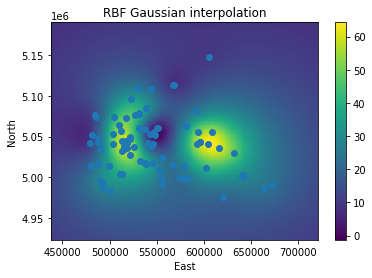

so2_gdf


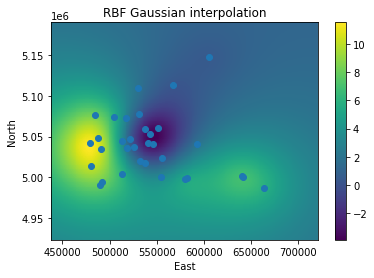

nh3_gdf


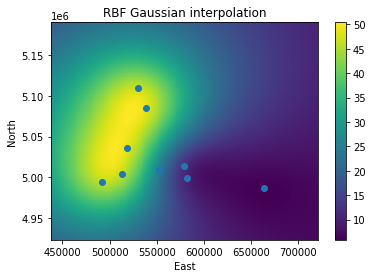

nox_gdf


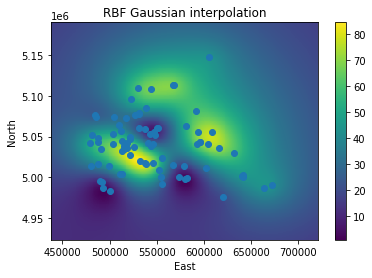

pm10_gdf


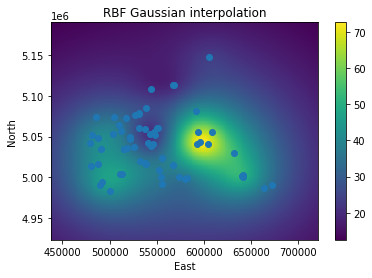

o3_gdf


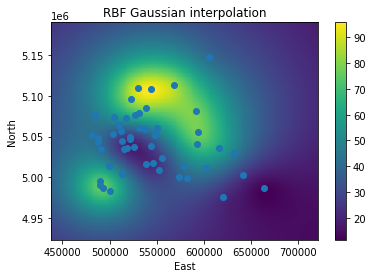

In [143]:
for key in aq_dict:
    east = aq_dict[key].geometry.x
    north = aq_dict[key].geometry.y
    value = aq_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='inverse', smooth=4.)
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Gaussian interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
    

temp_gdf


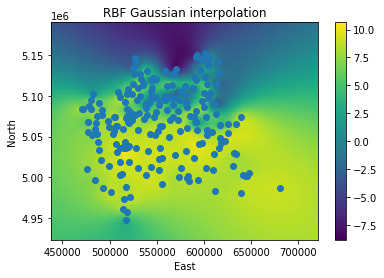

prec_gdf


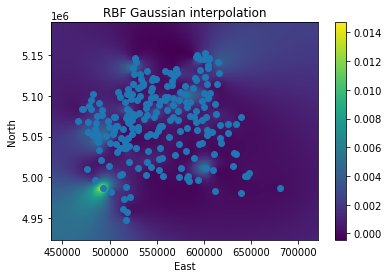

air_hum_gdf


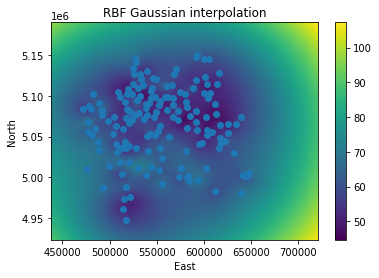

wind_dir_gdf


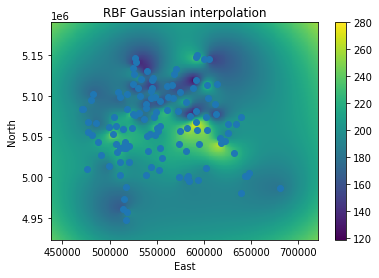

wind_speed_gdf


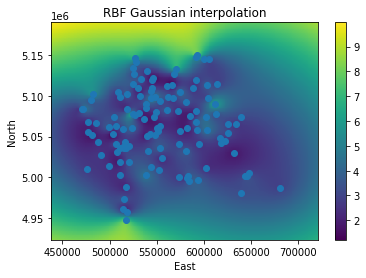

rad_glob_gdf


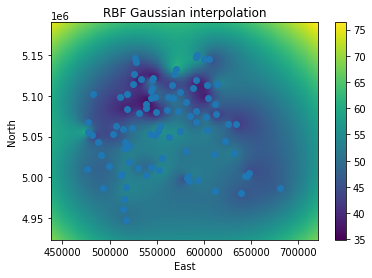

In [146]:
for key in meteo_dict:
    east = meteo_dict[key].geometry.x
    north = meteo_dict[key].geometry.y
    value = meteo_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='linear', smooth=4.)
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Gaussian interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)

Kriging:

In [ ]:
# for key in aq_dict:
#     east = aq_dict[key].geometry.x
#     north = aq_dict[key].geometry.y
#     value = aq_dict[key][['valore']]
#     n_sensor = aq_dict[key].shape[0]  #VERIFICARE nlags in funzione del numero di sensori (defaul 6)
#     lag = int(math.sqrt(n_sensor))
    
#     OK = OrdinaryKriging(east, north,value, weight=True,nlags= lag ,variogram_model='power',coordinates_type='euclidean') #verbose=True, enable_plotting=False, weight=w
#     # print(UniversalKriging.__doc__ )
#     gridded, ss1 = OK.execute('grid', xRange, yRange)
#     transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)
#     rasterCrs = CRS.from_epsg(32632)
#     #definition, register and close of interpolated raster
#     interpRaster = rio.open(cwd +'/temp/aq_krig_'+key[:(len(key)-4)]+'.tif',
#                                     'w',
#                                     driver='GTiff',
#                                     height=gridded.shape[0],
#                                     width=gridded.shape[1],
#                                     count=1,
#                                     nodata = -9999,
#                                     dtype=gridded.dtype,
#                                     crs=rasterCrs,
#                                     transform=transform,
#                                     )
#     interpRaster.write(gridded, 1)
#     interpRaster.close()
#     #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
#     ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/aq_krig_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
#                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
#     print(key)
#     plt.imshow(gridded)
#     plt.show()

In [ ]:
# for key in meteo_dict:
#     east = meteo_dict[key].geometry.x
#     north = meteo_dict[key].geometry.y
#     value = meteo_dict[key][['valore']]
#     n_sensor = meteo_dict[key].shape[0]  #VERIFICARE nlags in funzione del numero di sensori (defaul 6)
#     lag = int(math.sqrt(n_sensor))
    
#     OK = OrdinaryKriging(east, north, value, nlags= lag,
#                  weight=True, variogram_model='power',coordinates_type='euclidean') #verbose=True, enable_plotting=False, weight=w
#     # print(OrdinaryKriging.__doc__)
#     gridded, ss1 = OK.execute('grid', xRange, yRange)
#     transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)
#     rasterCrs = CRS.from_epsg(32632)
#     #definition, register and close of interpolated raster
#     interpRaster = rio.open(cwd +'/temp/meteo_krig_'+key[:(len(key)-4)]+'.tif',
#                                     'w',
#                                     driver='GTiff',
#                                     height= gridded.shape[0],
#                                     width= gridded.shape[1],
#                                     count=1,
#                                     nodata = -9999,
#                                     dtype=gridded.dtype,
#                                     crs=rasterCrs,
#                                     transform=transform,
#                                     )
#     interpRaster.write(gridded, 1)
#     interpRaster.close()
#     #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
#     ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/meteo_krig_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
#                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
#     print(key)
#     print(lag)
#     plt.imshow(gridded)
#     plt.show()

Notes:

In [ ]:
# INTERPOLATION USING GDAL
# pts = ogr.Open(cwd+'/temp/air_hum_st.gpkg', update = True)
# layer=pts.GetLayer()

# to generate a an interpolation using GDAL library
# pts = layer = None
# idw = gdal.Grid("idw.tif", (cwd+'/temp/air_hum_st.gpkg'), zfield="valore",
#                algorithm = "invdist", outputBounds = [ulx,uly,lrx,lry],
#                width = xsize, height = ysize)
# idw = None

# points = list(zip(air_hum_st.lng,air_hum_st.lat))

# gridded = griddata(points, value, (gridX,gridY), method='linear',fill_value=0)

# gridded = gridded.reshape((gridded.shape[0], gridded.shape[1]))

# plt.imshow(gridded)

In [ ]:
#Mask data using date range
#mask = (meteo_data['data'] >= start_date) & (meteo_data['data'] < end_date)
#meteo_data = meteo_data.loc[mask]
#meteo_data

In [ ]:
# print(list(arpa_df.columns))
# print(arpa_df['idsensore'].values)

In [ ]:
# results = client.get_all(dati, idsensore = "100", data='2022-01-20')
# results

In [ ]:
# arpa_df.loc[arpa_df['idsensore'] == "10377"]